<a href="https://colab.research.google.com/github/codebecker/generative-adversarial-networks/blob/cifar/dcgan_Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import imageio
import matplotlib
import torchvision as tv

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, batchnorm=True):
        """A generator for mapping a latent space to a sample space.
        The sample space for this generator is single-channel, 28x28 images
        with pixel intensity ranging from -1 to +1 for Mnist and 32x32 images for cifar.
        Args:
            latent_dim (int): latent dimension ("noise vector")
            batchnorm (bool): Whether or not to use batch normalization
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        self._init_modules()

    def _init_modules(self):
        """Initialize the modules."""
        # Project the input
        self.linear1 = nn.Linear(self.latent_dim, 256*7*7, bias=False)
        self.bn1d1 = nn.BatchNorm1d(256*7*7) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()

        # Convolutions output dim:[(W−K+2P)/S]+1 W = width of Input, K= Kernel Size(Square) P=Padding, S= Stride
        self.conv1 = nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=5,      #ouput dim Mnist:[(7−5+2*2)/1]+1 =7
                stride=1,
                padding=2,
                bias=False)
        self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None
# Transpose Convolutions output dim:[(W−(K-1)+2P-1)/S]+1 ,W = width of Input, K= Kernel Size(Square) P=Padding, S= Stride
# or Transpose Convolutions output dim:(W−1)*S-2P+(K-1)+1 ,W = width of Input, K= Kernel Size(Square) P=Padding, S= Stride
        self.conv2 = nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,         #ouput dim Mnist:(7-1)*2-2*1+(4-1)+1=14
                stride=2,              #ouput dim Cifar:(7-1)*2-2*0+(4-1)+1=16
                #padding=1,             
                padding=0,
                bias=False)
        self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None

        self.conv3 = nn.ConvTranspose2d(
                in_channels=64,
                #out_channels=1,
                out_channels=3,     #ouput channel for cifar-> RGB
                kernel_size=4,     #ouput dim Mnist:(14-1)*2-2*1+(4-1)+1=28
                stride=2,          #ouput dim Cifar:(16-1)*2-2*1+(4-1)+1=32
                padding=1,
                bias=False)
        self.tanh = nn.Tanh()
        #self.relu = F.relu()

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = self.linear1(input_tensor)
        intermediate = self.bn1d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = intermediate.view((-1, 256, 7, 7))

        intermediate = self.conv1(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv2(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv3(intermediate)
        output_tensor = self.tanh(intermediate)
        #output_tensor = F.relu(intermediate)
        return output_tensor

In [4]:

class Discriminator(nn.Module):
    def __init__(self):
        """A discriminator for discerning real from generated images.
        Images must be single-channel and 28x28 pixels for Mnist and 3 channel 32x32 pixels for Cifar.
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self._init_modules()

    def _init_modules(self):
        """Initialize the modules."""
        # Convolutions output dim:[(W−K+2P)/S]+1 W = width of Input, K= Kernel Size(Square) P=Padding, S= Stride
        self.conv1 = nn.Conv2d(
                #in_channels=1,              
                in_channels=3,
                out_channels=64,
                kernel_size=5,            #ouput dim Mnist:[(28−5+2*2)/2]+1 =14,5 =14
                stride=2,                 #ouput dim Cifar:[(32−5+2*0)/2]+1 =14,5 =14
                #padding=2,
                padding=0,
                bias=True)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout_2d = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(
                in_channels=64,
                out_channels=128,        
                kernel_size=5,          #ouput dim Mnist:[(14−5+2*2)/2]+1 = 7,5 =7
                stride=2,               #ouput dim Cifar:[(14−5+2*2)/2]+1 =7,5 =7
                padding=2,
                bias=True)

        self.linear1 = nn.Linear(128*7*7, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = self.conv1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = self.conv2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = intermediate.view((-1, 128*7*7))
        intermediate = self.linear1(intermediate)
        output_tensor = self.sigmoid(intermediate)

        return output_tensor

In [5]:
class DCGAN():
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=4, device='cpu', lr_d=1e-3, lr_g=2e-4):   #old batchsize=32
        """A very basic DCGAN class for generating MNIST digits
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            dataloader: a pytorch dataloader for loading images
            batch_size: training batch size. Must match that of dataloader
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample images from the generator.
        Images are returned as a 4D tensor of values between -1 and 1.
        Dimensions are (number, channels, height, width). Returns the tensor
        on cpu.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then use self.batch_size
        random latent vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        pred_real = self.discriminator(real_samples)
        #print(pred_real)
        #print(self.target_ones)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self, print_frequency=10, max_steps=0):
        """Train both networks for one epoch and return the losses.
        Args:
            print_frequency (int): print stats every `print_frequency` steps.
            max_steps (int): End epoch after `max_steps` steps, or set to 0
                             to do the full epoch.
        """
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, (real_samples, _) in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            #print(real_samples)
            ldr_, ldf_ = self.train_step_discriminator(real_samples)
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            loss_g_running += self.train_step_generator()
            if print_frequency and (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        return (loss_g_running, (loss_d_real_running, loss_d_fake_running))


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1; Elapsed time = 0s

Epoch 2; Elapsed time = 42s

Epoch 3; Elapsed time = 86s

Epoch 4; Elapsed time = 128s

Epoch 5; Elapsed time = 171s

Epoch 6; Elapsed time = 213s

Epoch 7; Elapsed time = 256s

Epoch 8; Elapsed time = 299s

Epoch 9; Elapsed time = 341s

Epoch 10; Elapsed time = 383s

Epoch 11; Elapsed time = 426s

Epoch 12; Elapsed time = 468s

Epoch 13; Elapsed time = 510s

Epoch 14; Elapsed time = 552s

Epoch 15; Elapsed time = 594s

Epoch 16; Elapsed time = 635s

Epoch 17; Elapsed time = 677s

Epoch 18; Elapsed time = 719s

Epoch 19; Elapsed time = 759s

Epoch 20; Elapsed time = 800s

Epoch 21; Elapsed time = 840s

Epoch 22; Elapsed time = 881s

Epoch 23; Elapsed time = 922s

Epoch 24; Elapsed time = 963s

Epoch 25; Elapsed time = 1003s

Epoch 26; Elapsed time = 1044s

Epoch 27; Elapsed time = 1086s

Epoch 28; Elapsed time = 1127s

Epoch 29; Elapsed time = 1169s

Epoch 30; Elapsed time = 1210s

Epoch 31; Elapsed time = 

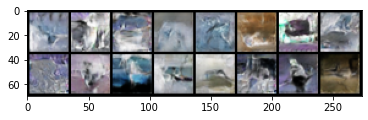

In [6]:
def main():
    import matplotlib.pyplot as plt
    from time import time
    batch_size = 16 #32
    epochs = 100
    latent_dim = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #MNISt dataset
    # transform = tv.transforms.Compose([
    #         tv.transforms.Grayscale(num_output_channels=1),
    #         tv.transforms.ToTensor(),
    #         tv.transforms.Normalize((0.5,), (0.5,))
    #         ])
    # dataset = ImageFolder(
    #         root=os.path.join("data", "mnist_png", "training"),
    #         transform=transform
    #         )
    # dataloader = DataLoader(dataset,
    #         batch_size=batch_size,
    #         shuffle=True,
    #         num_workers=2
    #         )

    #Cifar10 Dataset
    transform = tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = tv.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
    to_pil_image = tv.transforms.ToPILImage()
    # testset = torchvision.datasets.CIFAR10(root='./data', train=False,
    #                                    download=True, transform=transform)
    # testloader = torch.utils.data.DataLoader(testset, batch_size=4,
    #                                      shuffle=False, num_workers=2)

    # classes = ('plane', 'car', 'bird', 'cat',
    #        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    noise_fn = lambda x: torch.randn((x, latent_dim), device=device)
    #gan = DCGAN(latent_dim, noise_fn, dataloader, device=device, batch_size=batch_size) # MNIST dataset
    gan = DCGAN(latent_dim, noise_fn, trainloader, device=device, batch_size=batch_size)
    start = time()

    for i in range(100):
        print(f"Epoch {i+1}; Elapsed time = {int(time() - start)}s")
        gan.train_epoch()

    # # save the generated images as GIF file
    

    images = gan.generate_samples() * -1
    # imgs = [np.array(to_pil_image(img)) for img in images]
    # imageio.mimsave('C:\Users\Bibek\Documents\Python Scripts\KI_Labor\recording_lunar/generator_images.gif', imgs)

    ims = tv.utils.make_grid(images, normalize=True)
    plt.imshow(ims.numpy().transpose((1,2,0)))
    plt.show()


if __name__ == "__main__":
    main()